In [1]:

import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from keras.utils import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, TimeDistributed
import pandas as pd
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, Flatten, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

def prepare_dl_training_data(data_frame, sequence_max_len=128):
    """
    Prepare training data for BiLSTM model.

    Args:
        data_frame: DataFrame with training data.
        sequence_max_len: Max sequence length (default: 128).

    Returns:
        X_train: Input sequences (word indices, padded).
        y_train: Target sequences (tag indices, padded).
        vocab_size: Number of unique words.
        tag_count: Number of unique tags.
        word_index: Dict mapping words to indices.
        tag_index: Dict mapping tags to indices.
    """

    # Fill NA values in 'sentence_id' by forward filling
    data_frame["sentence_id"].fillna(method="ffill", inplace=True)

    # Group by 'sentence_id' and aggregate words and tags
    grouped_sentences = data_frame.groupby('sentence_id').apply(lambda s: [(w, t) for w, t in zip(s["words"].tolist(), s["tags"].tolist())]).tolist()

    # Create unique word list with 'ENDPAD'
    unique_words = list(dict.fromkeys(data_frame["words"].tolist())) + ["ENDPAD"]
    vocab_size = len(unique_words)

    # Create unique tag list
    unique_tags = list(dict.fromkeys(data_frame["tags"].tolist()))
    tag_count = len(unique_tags)

    # Map words and tags to indices
    word_index = {word: idx + 1 for idx, word in enumerate(unique_words)}
    tag_index = {tag: idx for idx, tag in enumerate(unique_tags)}

    # Convert sentences and tags to indices
    X_train = [[word_index[word[0]] for word in sentence] for sentence in grouped_sentences]
    y_train = [[tag_index[word[1]] for word in sentence] for sentence in grouped_sentences]

    # Pad sequences
    X_train = pad_sequences(sequences=X_train, maxlen=sequence_max_len, padding="post", value=vocab_size - 1)
    y_train = pad_sequences(sequences=y_train, maxlen=sequence_max_len, padding="post", value=tag_index["O"])

    return X_train, y_train, vocab_size, tag_count, word_index, tag_index


def prepare_dl_testing_data(data_frame, word_index, tag_index, vocab_size, sequence_max_len=128):
    """
    Prepare test data for BiLSTM model.

    Args:
        data_frame: DataFrame with test data.
        word_index: Dict mapping words to indices.
        tag_index: Dict mapping tags to indices.
        sequence_max_len: Max sequence length (default: 128).

    Returns:
        X_test: Input sequences (word indices, padded).
        y_test: Target sequences (tag indices, padded).
    """

    # Fill NA values in 'sentence_id' by forward filling
    data_frame["sentence_id"].fillna(method="ffill", inplace=True)

    # Group by 'sentence_id' and aggregate words and tags
    grouped_sentences = data_frame.groupby('sentence_id').apply(lambda s: [(w, t) for w, t in zip(s["words"].tolist(), s["tags"].tolist())]).tolist()

    # Convert sentences to word indices
    X_test = [[word_index.get(word[0], 0) for word in sentence] for sentence in grouped_sentences]
    y_test = [[tag_index[word[1]] for word in sentence] for sentence in grouped_sentences]

    # Pad sequences
    X_test = pad_sequences(sequences=X_test, maxlen=sequence_max_len, padding="post", value=vocab_size - 1)
    y_test = pad_sequences(sequences=y_test, maxlen=sequence_max_len, padding="post", value=tag_index["O"])

    return X_test, y_test



def compute_accuracy(true_labels, predicted_labels):
    """
    Calculate accuracy excluding 'O' tags.

    Args:
        true_labels: List of true tags.
        predicted_labels: List of predicted tags.

    Returns:
        Accuracy score.
    """

    indices = [index for index, label in enumerate(true_labels) if label != 0]
    true_filtered = [true_labels[i] for i in indices]
    predicted_filtered = [predicted_labels[i] for i in indices]

    return accuracy_score(true_filtered, predicted_filtered)


def evaluate_dl(true_labels, predicted_labels, reverse_tag_index):
    """
    Evaluate predictions and display metrics and confusion matrix.

    Args:
        true_labels: List of true tags.
        predicted_labels: List of predicted tags.
        reverse_tag_index: Dict mapping tag indices to tags.

    Returns:
        None
    """

    accuracy = compute_accuracy(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=reverse_tag_index.values(), yticklabels=reverse_tag_index.values())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def predict_dl(model, X_input):
    """
    Predict labels using the BiLSTM model.

    Args:
        model: BiLSTM model.
        X_input: Input data.

    Returns:
        Predicted labels.
    """

    y_pred = model.predict(X_input)
    y_pred = np.argmax(y_pred, axis=-1)
    y_pred[y_pred > 16] = 16

    return y_pred

In [2]:
train = pd.read_csv("data/train_data_ner.csv")
test = pd.read_csv("data/test_data_ner.csv")
sentences_train, tags_train, num_words, num_tags, word2idx, tag2idx = prepare_dl_training_data(train)
sentences_test, tags_test = prepare_dl_testing_data(test, word2idx, tag2idx,num_words)

/var/folders/yb/mm0hrmlx3g9dv10c735753m00000gn/T/ipykernel_19498/3958079634.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_frame["sentence_id"].fillna(method="ffill", inplace=True)
/var/folders/yb/mm0hrmlx3g9dv10c735753m00000gn/T/ipykernel_19498/3958079634.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame["sentence_id"].fillna(method="ffill", inplace=True)
/var/folders/yb/mm0hrmlx3g9dv10c735753m00000gn/T/ipykernel_

1199/1199 [==============================] - 155s 128ms/step
Accuracy: 0.8062
F1 Score: 0.9938


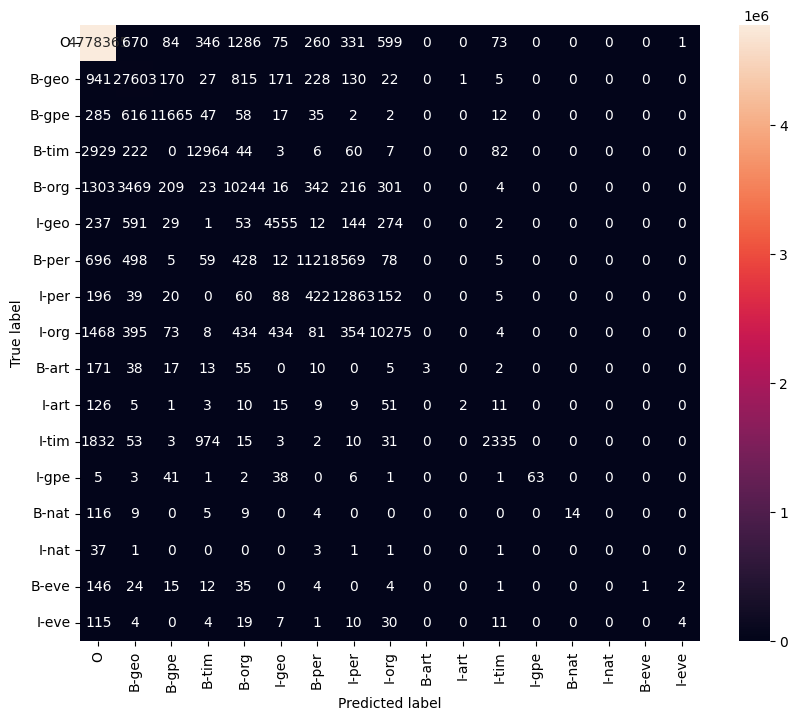

In [6]:
def build_BiLSTM_model(vocab_size, sequence_max_len=128):
    """
    Build a BiLSTM model.

    Args:
        vocab_size: Number of unique words.
        sequence_max_len: Max sequence length (default: 128).

    Returns:
        model: Compiled BiLSTM model.
    """

    model = Sequential()
    model.add(InputLayer(input_shape=(sequence_max_len,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=sequence_max_len, input_length=sequence_max_len))
    model.add(SpatialDropout1D(0.1))
    model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

# Load model Checkpoint bilstm.weights.h5
model = build_BiLSTM_model(num_words)
model.load_weights("bilstm.weights.h5")

# sentences_test, tags_test
tag_dict_rev = {v: k for k, v in tag2idx.items()}

y_train_pred = predict_dl(model, sentences_train)
evaluate_dl(tags_train.flatten().tolist(), y_train_pred.flatten().tolist(), tag_dict_rev)